# Analysis of Russian YouTube Data

In [359]:
import os
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from IPython.display import HTML, Image

# Index

1. Correlation between likes, views, comments and dislikes
2. Top 10 most viewed, liked, disliked, commented videos, most popular channels
3. What are the most posted/viewed/commented/liked/disliked categories?
4. Engagement metrics per category: what are the categories that viewers like or hate the most?
5. How long are the videos trending and what are the most and longest trending cetegories?
6. Most popular tags and words in description, most popular tags in the most disliked category. 
7. Which are the videos which are removed or have disabled comments or ratings?

## 0. Preparing the data

In [2]:
pd.options.display.float_format = '{:,.2f}'.format

In [158]:
df = pd.read_csv('RUvideos.csv',engine='python')

In [4]:
df.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,gDuslQ9avLc,17.14.11,Захар и Полина учатся экономить,Т—Ж БОГАЧ,22,2017-11-13T09:09:31.000Z,"захар и полина|""учимся экономить""|""копить день...",62408,334,190,50,https://i.ytimg.com/vi/gDuslQ9avLc/default.jpg,False,False,False,"Знакомьтесь, это Захар и Полина. Вместе с ними..."
1,AOCJIFEA_jE,17.14.11,Биржа Мемов #29. Большой выпуск,Druzhko Show,22,2017-11-13T17:32:11.000Z,"биржа мемов|""лев шагинян""|""мемы""|""пикчи""|""друж...",330043,43841,2244,2977,https://i.ytimg.com/vi/AOCJIFEA_jE/default.jpg,False,False,False,"В 29 выпуске Дружко Шоу Сергей сказал, что Бир..."
2,VAWNQDgwwOM,17.14.11,ХАЙП КЭМП - СВОЙ СРЕДИ ЧУЖИХ,Юлик,24,2017-11-13T16:11:31.000Z,"юмор|""комедия""|""влог""|""блог""|""смешно""|""смешное...",424596,49854,714,2944,https://i.ytimg.com/vi/VAWNQDgwwOM/default.jpg,False,False,False,http://kapitany.ru/!Yulik.cap - Факультет #Кап...
3,gknkFwKQfHg,17.14.11,Сочная кесадилья с курицей,Hochland,22,2017-11-13T06:51:10.000Z,"хохланд|""сыр""|""рецепты""|""как приготовить""|""вку...",112851,3566,122,80,https://i.ytimg.com/vi/gknkFwKQfHg/default.jpg,False,False,False,*** как готовить ресторанные блюда дома
4,3sYvZcwzZr8,17.14.11,КЛИПЫ РОДИТЕЛЕЙ НА ШКОЛЬНЫЙ ВЫПУСКНОЙ,Совергон,24,2017-11-13T16:52:36.000Z,"Совергон|""Sovergon""|""клипы""|""родители""|""школа""...",243469,36216,631,1692,https://i.ytimg.com/vi/3sYvZcwzZr8/default.jpg,False,False,False,❏ КОНКУРС КАПИТАНЫ: http://kapitany.ru/!Soverg...


In [12]:
# Some common statistics
df.describe()

,category_id,views,likes,dislikes,comment_count
count,"40,739","40,739","40,739","40,739","40,739"
mean,20,"240,715","12,435","1,475","1,775"
std,8,"934,511","60,383","8,582","11,275"
min,1,117,0,0,0
25%,20,"22,588",402,31,73
50%,22,"66,316","1,880",128,309
75%,25,"195,131","7,791",586,"1,107"
max,43,"62,796,390","4,470,923","884,967","905,925"


In [159]:
#Converting into dates
df['trending_date'] = pd.to_datetime(df['trending_date'], format='%y.%d.%m')
df['publish_time'] = pd.to_datetime(df['publish_time'])

In [160]:
# Inserting category names

df['category_id'] = df['category_id'].astype(str)

category_id = {}
with open('Ru_category_id.json', 'r') as f:
    cat_name = json.load(f)
    for category in cat_name['items']:
        category_id[category['id']] = category['snippet']['title']
        
df.insert(4, 'category_name', df['category_id'].map(category_id))
df['category_name'].fillna('Nonprofits & Activism', inplace = True)
df_trend = df.copy() # using for trend analysis later

In [161]:
#Checking for duplicates and removing them to not count videos trending for several days several times
df[df.duplicated('video_id') == True]
df.drop_duplicates('video_id', inplace = True, keep = 'last')

#### Distributions of views, likes, dislikes and comments

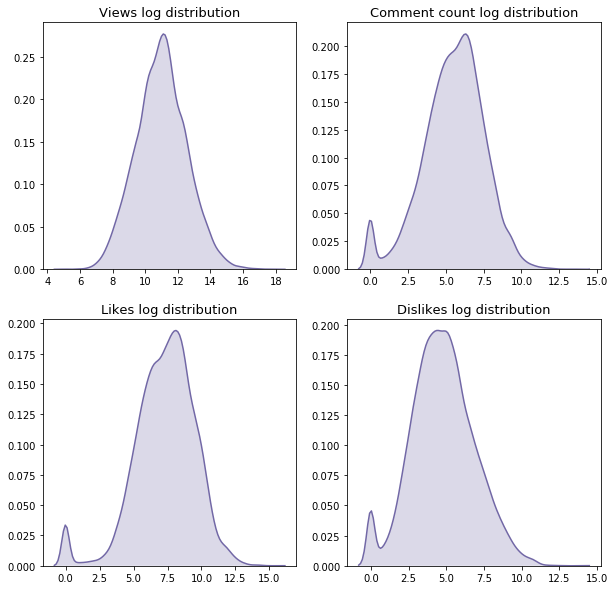

In [174]:
# Scaling the variables into logarithmic scale because we have some outliers that are distorting the picture
plt.figure(figsize = (10,10))
plt.subplot(221)
ax1 = sns.kdeplot(np.log1p(df['views']), color = '#7268A6', shade = True, legend = False)
ax1.set_title('Views log distribution', fontsize = 13)

plt.subplot(222)
ax2 = sns.kdeplot(np.log1p(df['comment_count']), color = '#7268A6', shade = True, legend = False)
ax2.set_title('Comment count log distribution', fontsize = 13)

plt.subplot(223)
ax3 = sns.kdeplot(np.log1p(df['likes']), color = '#7268A6', shade = True, legend = False)
ax3.set_title('Likes log distribution', fontsize = 13)

plt.subplot(224)
ax4 = sns.kdeplot(np.log1p(df['dislikes']), color = '#7268A6', shade = True, legend = False)
ax4.set_title('Dislikes log distribution', fontsize = 13);

Comments, likes and dislikes have a very similar distribution, views log has a normal distribution. We can see that there is a considerable number of people who do not engage on a deeper level (such as commenting, liking/disliking) and prefer to just watch videos. Let's look at correlation between numerical variables.

### Correlation between numerical variables

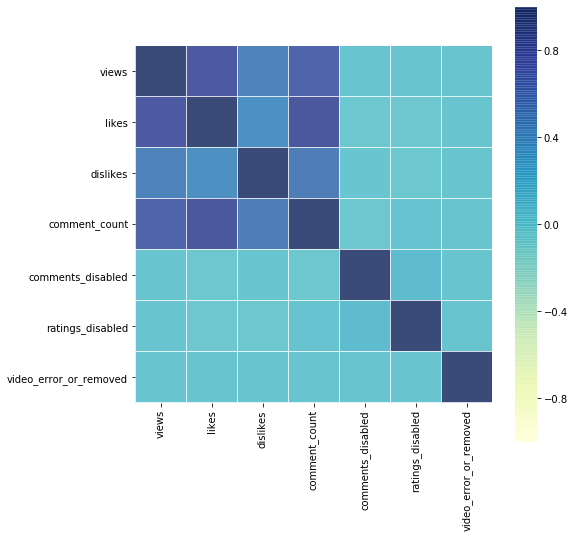

In [139]:
plt.figure(figsize = (8,8))
ax = sns.heatmap(df.corr(), alpha = 0.8, cmap = 'YlGnBu', linewidths=.3, square = True, vmin=-1, vmax=1)

#Adjusting bottom and top rows
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5);

### Top 10 ...

#### ...most viewed videos over the last year

In [7]:
def path_to_image_html(path):
    '''
     This function essentially convert the image url to 
     '<img src="'+ path + '"/>' format. And one can put any
     formatting adjustments to control the height, aspect ratio, size etc.
     within as in the below example. 
    '''
    return '<img src="'+ path + '" style=max-height:124px;"/>'

In [8]:
most_viewed = df[df['publish_time'].dt.year == 2017][['title', 'views', 'thumbnail_link']].sort_values(by = 'views',ascending = False).head(10)
HTML(most_viewed.to_html(escape=False, formatters=dict(thumbnail_link=path_to_image_html)))

,title,views,thumbnail_link
4833,YouTube Rewind: The Shape of 2017 | #YouTubeRewind,52611730,
2574,BTS (방탄소년단) 'MIC Drop (Steve Aoki Remix)' Official MV,20565795,
2037,Post Malone - rockstar ft. 21 Savage,11202281,
5704,TWICE Heart Shaker M/V,11028219,
8632,CLASH ROYALE: EPIC COMEBACK!,9365576,
1122,"What's new, Atlas?",8533826,
7643,Katy Perry - Hey Hey Hey (Official),7842032,
5639,READY PLAYER ONE - Official Trailer 1 [HD],7323028,
3524,Avengers: Infinity War Trailer Tease,7281189,
5085,Why I'm not in YouTube Rewind 2017,6896028,


The most viewed videos are mostly MVs or movie trailers.

#### ... most liked videos over the last year

In [9]:
most_liked = df[df['publish_time'].dt.year == 2017][['title', 'likes', 'thumbnail_link']].sort_values(by = 'likes',ascending = False).head(10)
HTML(most_liked.to_html(escape=False, formatters=dict(thumbnail_link=path_to_image_html)))

,title,likes,thumbnail_link
2574,BTS (방탄소년단) 'MIC Drop (Steve Aoki Remix)' Official MV,2320662,
4833,YouTube Rewind: The Shape of 2017 | #YouTubeRewind,1891836,
643,BTS (방탄소년단) 'MIC Drop (Steve Aoki Remix)' Official Teaser,789772,
2037,Post Malone - rockstar ft. 21 Savage,686145,
5704,TWICE Heart Shaker M/V,652347,
3660,Demi Lovato - Tell Me You Love Me,633645,
6497,Ed Sheeran - Perfect Symphony (with Andrea Bocelli),532902,
5085,Why I'm not in YouTube Rewind 2017,513560,
9968,СОБОЛЕВ - ДО ПОСЛЕДНЕГО [ПРЕМЬЕРА КЛИПА],489879,
8232,Eminem - Walk On Water (Official Video) ft. Beyoncé,432692,


Even more MVs.

#### ... most disliked videos over the last year

In [10]:
most_disliked = df[df['publish_time'].dt.year == 2017][['title', 'dislikes', 'thumbnail_link']].sort_values(by = 'dislikes',ascending = False).head(10)
HTML(most_disliked.to_html(escape=False, formatters=dict(thumbnail_link=path_to_image_html)))

,title,dislikes,thumbnail_link
4833,YouTube Rewind: The Shape of 2017 | #YouTubeRewind,884967,
8959,Объявляем забастовку избирателей,187583,
7235,Выборы объявлены. Наши ближайшие планы,177606,
6975,Уважаемый Владимир Владимирович,157911,
5837,Марьяна Ро & FatCat - Мега-звезда,156287,
9829,Новогоднее обращение Алексея Навального,149739,
9037,Зачем нужна забастовка? 28 января выходим на улицы,146913,
7831,Как пресс-секретарь Путина квартиру в Париже купил,120690,
8280,Что Навальный предлагает полицейским,117050,
6232,Программа Алексея Навального,116543,


Almost all of the videos refer to politics (opposition, Navalnyi, elections, protests). Let's see if those videos are among the most discussed ones as well.

#### ... most commented videos over the last year

In [11]:
most_commented = df[df['publish_time'].dt.year == 2017][['title', 'comment_count', 'thumbnail_link']].sort_values(by = 'comment_count',ascending = False).head(10)
HTML(most_commented.to_html(escape=False, formatters=dict(thumbnail_link=path_to_image_html)))

,title,comment_count,thumbnail_link
4833,YouTube Rewind: The Shape of 2017 | #YouTubeRewind,702790,
2574,BTS (방탄소년단) 'MIC Drop (Steve Aoki Remix)' Official MV,477215,
5704,TWICE Heart Shaker M/V,105487,
9731,РОЗЫГРЫШ ОЧЕНЬ МОЩНОГО КОМПЬЮТЕРА АФОНЯ TV,104564,
823,Ненавижу Android?,100581,
5837,Марьяна Ро & FatCat - Мега-звезда,96199,
5090,Xiaomi Mi Mix 2 - возвращение йоба смартфона,96063,
8959,Объявляем забастовку избирателей,88358,
6859,ОБЗОР ТАЧЕК КОМАНДЫ А. ДР Глазунова. Трансформатор,77702,
643,BTS (방탄소년단) 'MIC Drop (Steve Aoki Remix)' Official Teaser,72376,


Interesting, the most commented videos are not the political ones (except for 1 video). Seems like people tend to just hit dislike button without engaging much in the discussion.

### ... most popular channels

In [229]:
df['channel_title'].value_counts().head(10)

Анатолий Шарий                                         179
Эхо Москвы                                             173
Модные Практики с Паукште Ириной Михайловной           163
Россия 24                                              150
След - новый сезон                                     146
Калнина Наталья                                        142
kamikadzedead                                          138
PanArmenian TV                                         137
Конец близок или свидетели финансового апокалипсиса    135
Акыркы Кабарлар - Санжар Калматай                      127
Name: channel_title, dtype: int64

A lot of those look like political or controversy channels.

### What are the most posted/viewed/commented/liked/disliked categories?

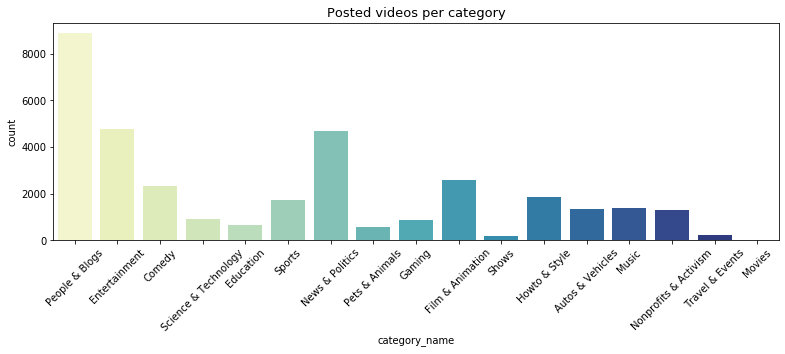

In [13]:
plt.figure(figsize = (13,4))
ax = sns.countplot(df['category_name'],  palette= 'YlGnBu')
ax.set_title('Posted videos per category', fontsize = 13)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45);

The most posted number of videos were dedicated to People & Blogs, other notable categories - Entertainment and News & Politics. The least number of posts belongs to Movies, Travel and Shows.

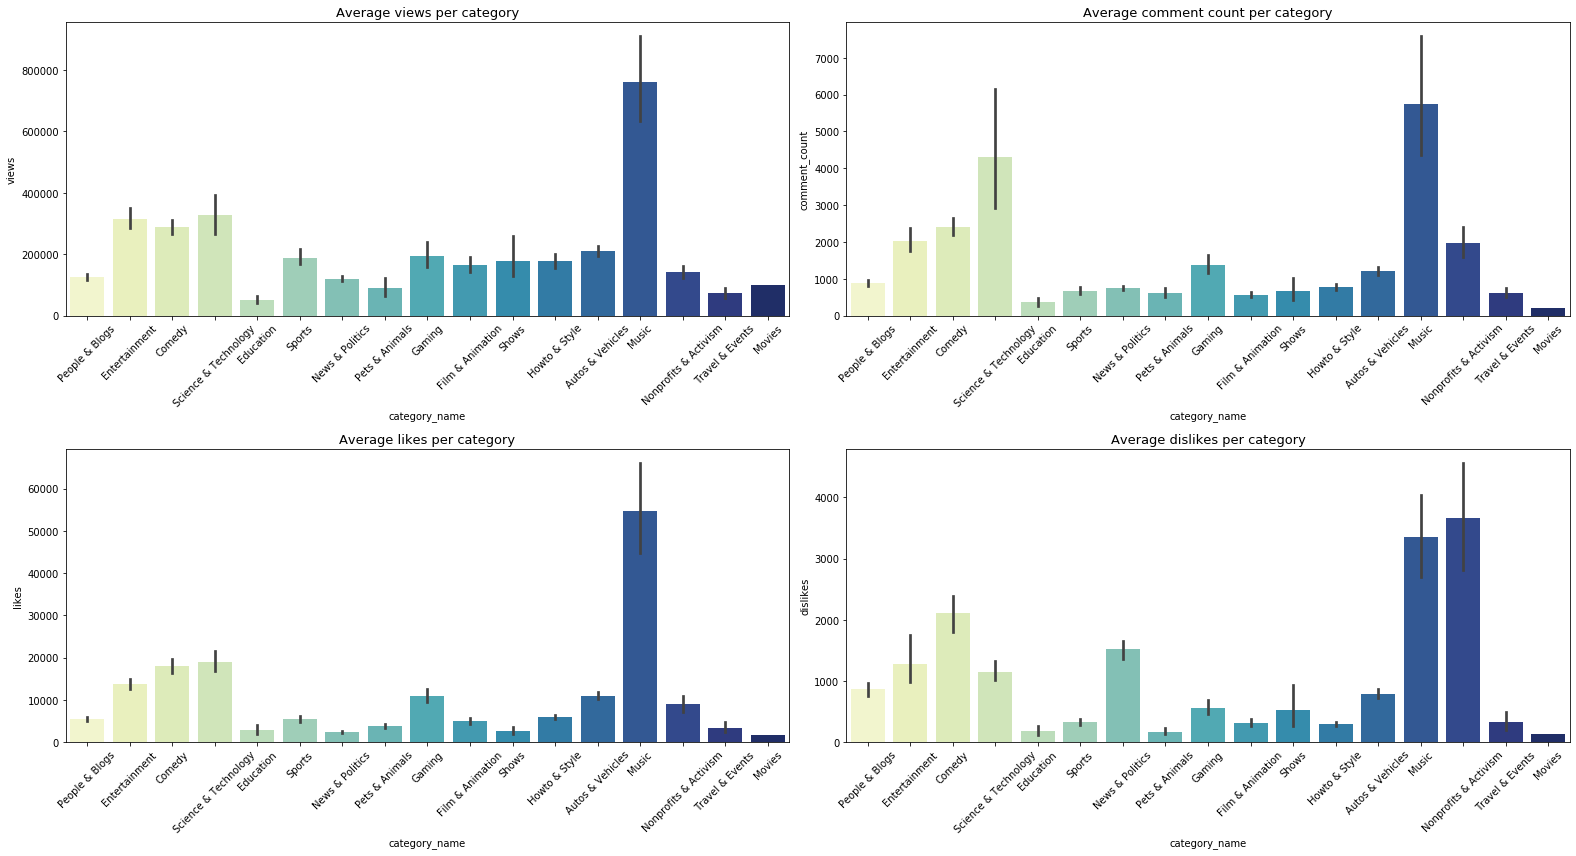

In [14]:
plt.figure(figsize = (22,12))
plt.subplot(221)
ax1 = sns.barplot(x = df['category_name'],y = df['views'], palette= 'YlGnBu')
ax1.set_title('Average views per category', fontsize = 13)
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=45)
plt.tight_layout()

plt.subplot(222)
ax2 = sns.barplot(x = df['category_name'],y = df['comment_count'], palette= 'YlGnBu')
ax2.set_title('Average comment count per category', fontsize = 13)
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=45)
plt.tight_layout()

plt.subplot(223)
ax3 = sns.barplot(x = df['category_name'],y = df['likes'], palette= 'YlGnBu')
ax3.set_title('Average likes per category', fontsize = 13)
ax3.set_xticklabels(ax3.get_xticklabels(),rotation=45)
plt.tight_layout()

plt.subplot(224)
ax4 = sns.barplot(x = df['category_name'],y = df['dislikes'], palette= 'YlGnBu')
ax4.set_title('Average dislikes per category', fontsize = 13)
ax4.set_xticklabels(ax4.get_xticklabels(),rotation=45)
plt.tight_layout();

Despite the fact that MVs are far from the most posted videos, they have the highest mean number of views, comments, likes and dislikes, meaning that they are the most user engaging category.

At the same time being the most posted category, People and Blogs, does not attract as many viewers.

It can also be noted that russian users for some reason seem to dislike comedy videos, looks like we have tough sense of humour) Nonprofits videos also seem to be highly disliked.

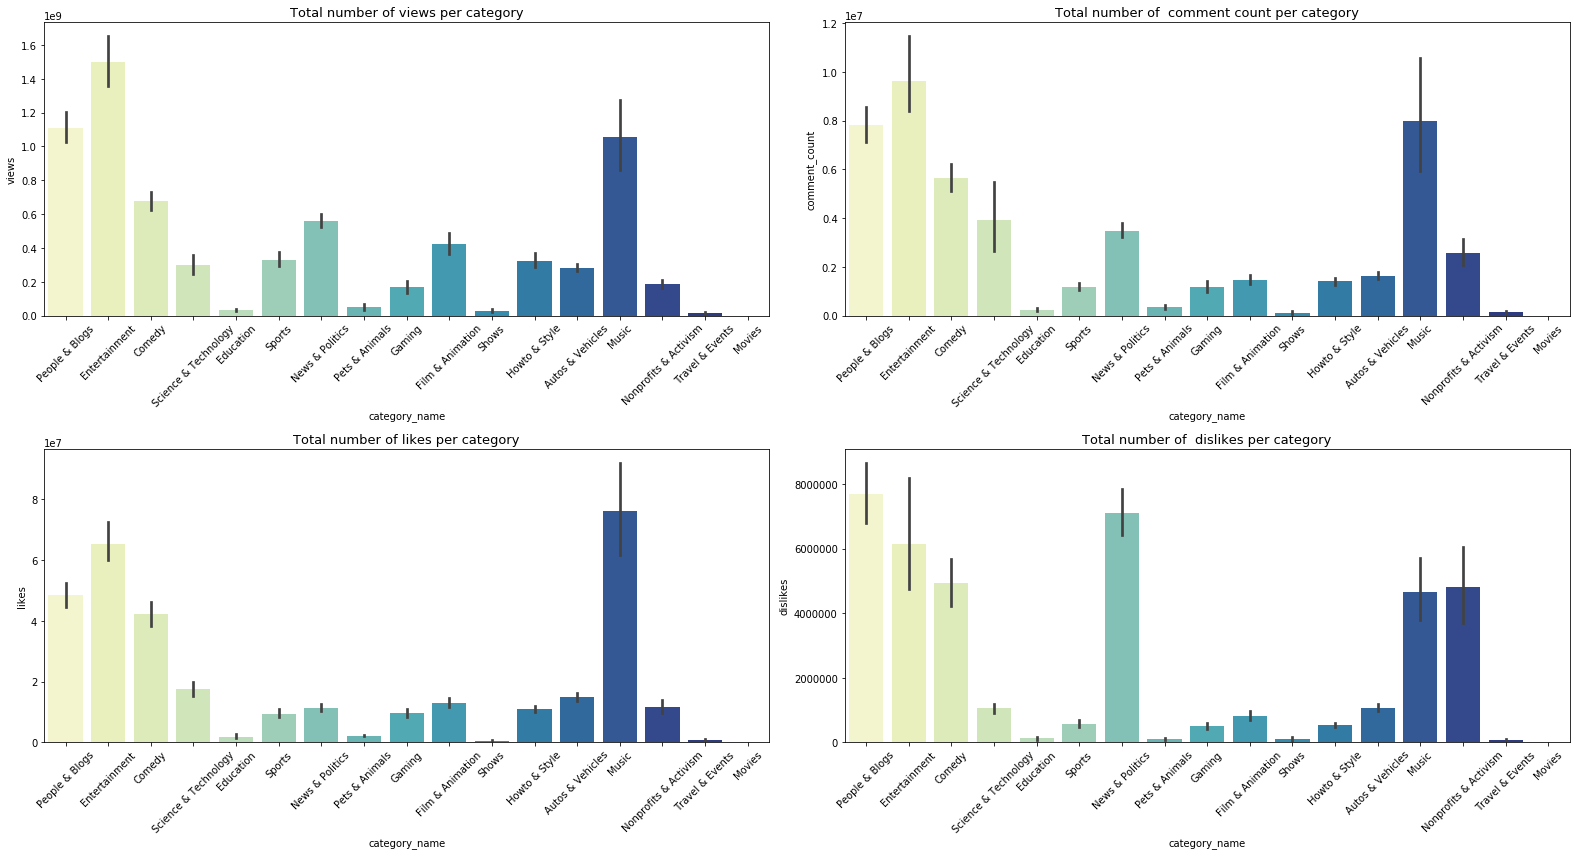

In [15]:
plt.figure(figsize = (22,12))
plt.subplot(221)
ax1 = sns.barplot(x = df['category_name'],y = df['views'], palette= 'YlGnBu', estimator = sum)
ax1.set_title('Total number of views per category', fontsize = 13)
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=45)
plt.tight_layout()

plt.subplot(222)
ax2 = sns.barplot(x = df['category_name'],y = df['comment_count'], palette= 'YlGnBu', estimator = sum)
ax2.set_title('Total number of  comment count per category', fontsize = 13)
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=45)
plt.tight_layout()

plt.subplot(223)
ax3 = sns.barplot(x = df['category_name'],y = df['likes'], palette= 'YlGnBu', estimator = sum)
ax3.set_title('Total number of likes per category', fontsize = 13)
ax3.set_xticklabels(ax3.get_xticklabels(),rotation=45)
plt.tight_layout()

plt.subplot(224)
ax4 = sns.barplot(x = df['category_name'],y = df['dislikes'], palette= 'YlGnBu', estimator = sum)
ax4.set_title('Total number of  dislikes per category', fontsize = 13)
ax4.set_xticklabels(ax4.get_xticklabels(),rotation=45)
plt.tight_layout();

Looks like total number of dislikes is the very high for News and Politics, despite not being on top in the mean. That confirms what we've already seen before: almost all af the most disliked videos are political, meaning that there are a few of highly disliked videos that significantly increase the totals.

We can also see that there is a high nimber of outliers in the People and Entertainment due to the difference in the mean and total sum indicators.

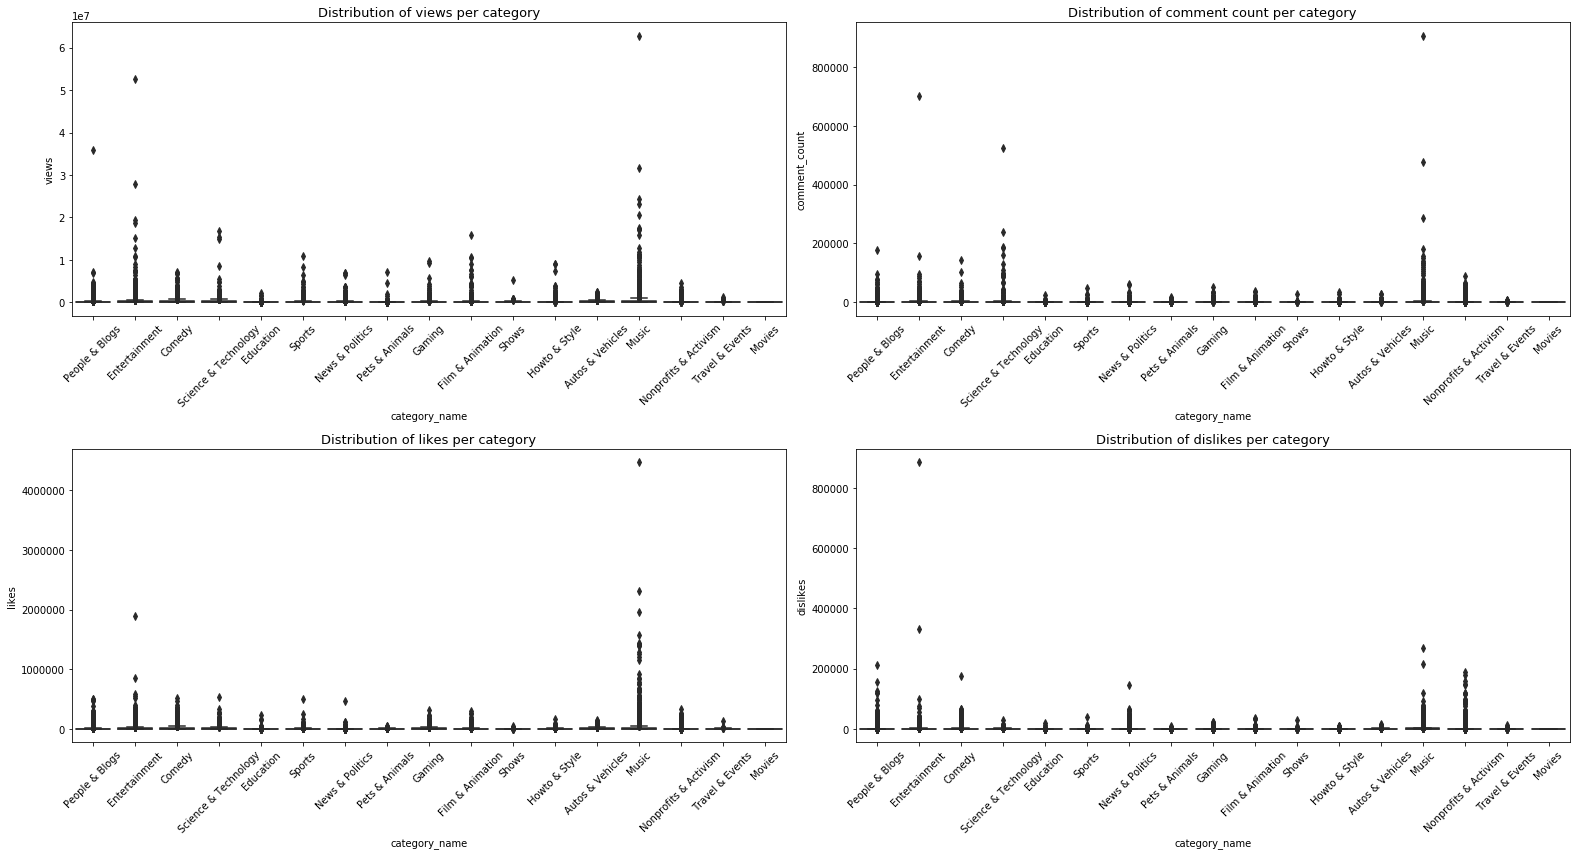

In [16]:
plt.figure(figsize = (22,12))
plt.subplot(221)
ax1 = sns.boxplot(x = df['category_name'],y = df['views'], palette= 'YlGnBu')
ax1.set_title('Distribution of views per category', fontsize = 13)
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=45)
plt.tight_layout()

plt.subplot(222)
ax2 = sns.boxplot(x = df['category_name'],y = df['comment_count'], palette= 'YlGnBu')
ax2.set_title('Distribution of comment count per category', fontsize = 13)
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=45)
plt.tight_layout()

plt.subplot(223)
ax3 = sns.boxplot(x = df['category_name'],y = df['likes'], palette= 'YlGnBu')
ax3.set_title('Distribution of likes per category', fontsize = 13)
ax3.set_xticklabels(ax3.get_xticklabels(),rotation=45)
plt.tight_layout()

plt.subplot(224)
ax4 = sns.boxplot(x = df['category_name'],y = df['dislikes'], palette= 'YlGnBu')
ax4.set_title('Distribution of dislikes per category', fontsize = 13)
ax4.set_xticklabels(ax4.get_xticklabels(),rotation=45)
plt.tight_layout();

### Engagement metrics per category: what are the categories that viewers like or hate the most?

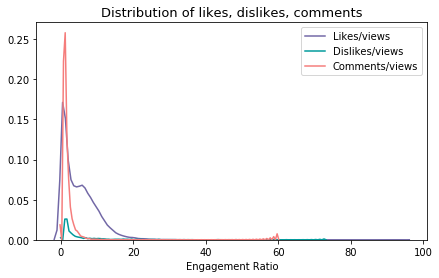

In [55]:
plt.figure(figsize = (7,4))
ax = sns.distplot(df['likes']*100/df['views'], color = '#7268A6', hist = False, label = 'Likes/views')
ax = sns.distplot(df['dislikes']*100/df['views'], color = '#009A9C', hist = False, label = 'Dislikes/views')
ax = sns.distplot(df['comment_count']*100/df['views'], color = '#F57D7C', hist = False, label = 'Comments/views')
ax.set_title('Distribution of likes, dislikes, comments per views', fontsize = 13)
ax.set_xlabel('Engagement Rate');

In [17]:
round(np.mean(df['likes']/df['views'])*100,2)

4.79

In [18]:
round(np.mean(df['dislikes']/df['views'])*100,2)

0.66

In [19]:
round(np.mean(df['comment_count']/df['views'])*100,2)

0.82

So on average only a small proportion of users tends to be active on the platform (about 5%). The majority of people don't comment on videos.

It will be interesting to look at whether people tend to watch content that they mostly don't agree with, particularly in the category News and Politics.

#### Dislikes/views, likes/views, comments/views and likes/dislikes per category

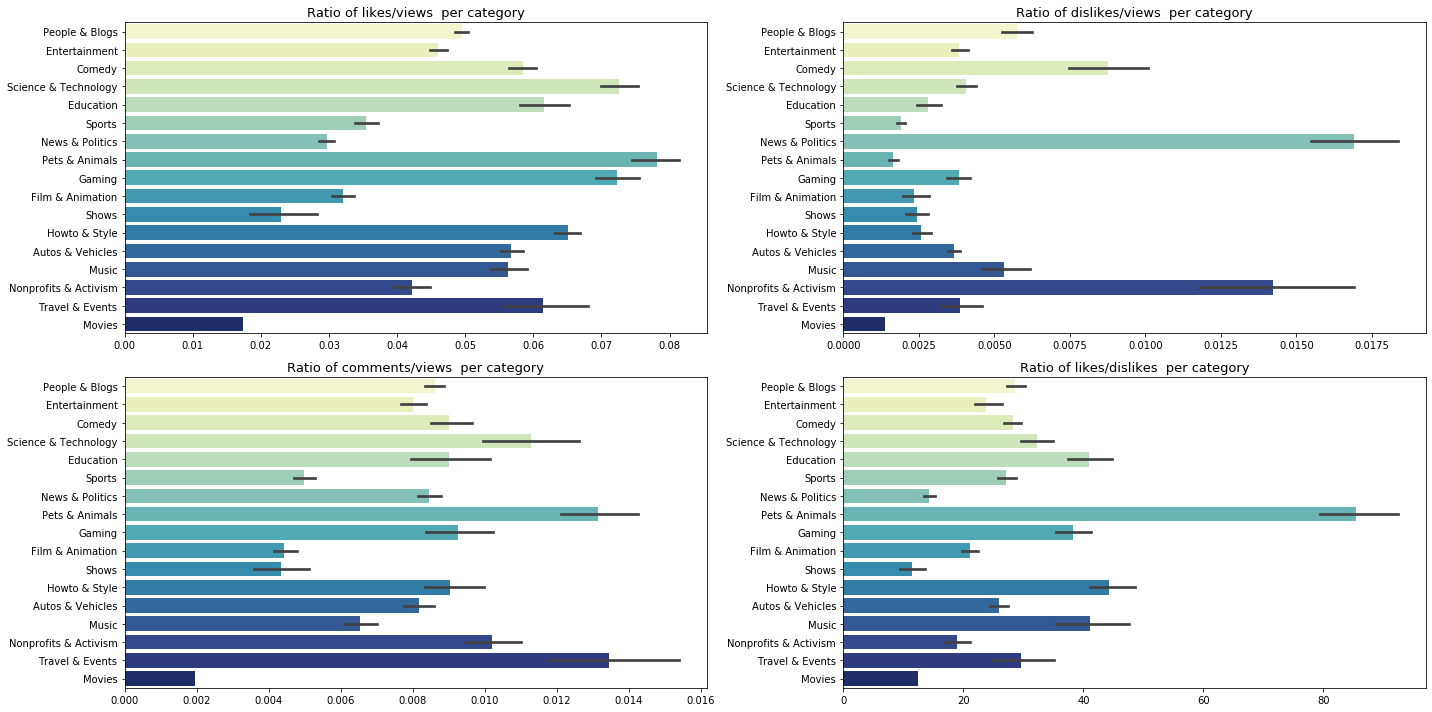

In [20]:
plt.figure(figsize = (20,10))
plt.subplot(221)
ax1 = sns.barplot(y = df['category_name'], x = df['likes']/df['views'], palette= 'YlGnBu')
ax1.set_title('Ratio of likes/views  per category', fontsize = 13)
ax1.set_ylabel('')

plt.subplot(222)
ax2 = sns.barplot(y = df['category_name'], x = df['dislikes']/df['views'], palette= 'YlGnBu')
ax2.set_title('Ratio of dislikes/views  per category', fontsize = 13)
ax2.set_ylabel('')
plt.tight_layout()

plt.subplot(223)
ax3 = sns.barplot(y = df['category_name'], x = df['comment_count']/df['views'], palette= 'YlGnBu')
ax3.set_title('Ratio of comments/views  per category', fontsize = 13)
ax3.set_ylabel('')
plt.tight_layout()

plt.subplot(224)
ax4 = sns.barplot(y = df['category_name'], x = df['likes']/(df['dislikes']+1), palette= 'YlGnBu')
ax4.set_title('Ratio of likes/dislikes  per category', fontsize = 13)
ax4.set_ylabel('')
plt.tight_layout();

As can be seen on general people tend to watch content that they like or are neurtal about: ratios of likes per views is higher than this of the dislikes/views. The majority of viewers who do not support the content belong to the category News and Politics (1.7%). That, however, is almost twice less than the number of people who watched the content and explicitly liked it (3%). At the same time people tend to not really engage in debates about it (ratio of comments/views is not the highest). Nonprofits has once again very high unacceptance.

Pets and Animals, Gaming, Travel and Events, Education, Science and technology seem to attract mainly positive viewers. 

People tend to love anilmals and pets and apparently comment a lot on those videos (probably expressing their love for animals). There is a different situation with travel and events: average like/dislike ratio is low but the comment/views ratio is one of the highest (probably people discuss the destinations to travel without much positive or negative sentiment).

Users who watch movies and shows tend to express the least engagement apart from views. 


### How long are the videos trending and what are the most trending cetegories?

In [188]:
df = df.rename(columns = {'trending_date':'last_trending_date'})
df_trend = df_trend.drop_duplicates('video_id', keep = 'first').rename(columns = {'trending_date':'first_trending_date'})
full_df = pd.merge(df, df_trend, on = ['video_id', 'channel_title',
       'category_name', 'category_id', 'publish_time', 'tags', 'thumbnail_link',
       'comments_disabled', 'ratings_disabled', 'video_error_or_removed',
       'description', 'title'])
full_df['time_trending'] = full_df['last_trending_date'].dt.date - full_df['first_trending_date'].dt.date
full_df['time_to_become_trend'] = full_df['first_trending_date'].dt.date - full_df['publish_time'].dt.date
full_df['days_trending'] = (full_df['last_trending_date'].dt.date - full_df['first_trending_date'].dt.date).dt.days
full_df['days_to_become_trend'] = (full_df['first_trending_date'].dt.date - full_df['publish_time'].dt.date).dt.days

In [189]:
full_df['time_to_become_trend'].mean()

Timedelta('2 days 06:03:00.026694')

On average it takes 2 days for the video to become  trending.

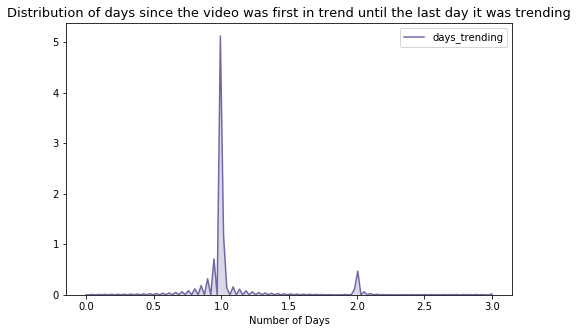

In [184]:
plt.figure(figsize = (8,5))
ax = sns.kdeplot(full_df['days_trending'].dt.days,color = '#7268A6', shade = True)
ax.set_title('Distribution of days since the video was first in trend until the last day it was trending', fontsize = 13)
ax.set_xlabel('Number of Days');

The majority of videos keep trending for a day only.

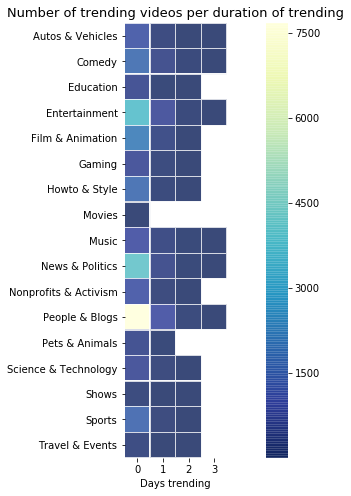

In [214]:
plt.figure(figsize = (14,8))
ax = sns.heatmap(full_df.groupby(['category_name','days_trending'])['video_id'].count().unstack(),cmap= 'YlGnBu_r', linewidths=.3, square = True, alpha = 0.8)
#Adjusting bottom and top rows
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.set_ylabel('')
ax.set_xlabel('Days trending')
ax.set_title('Number of trending videos per duration of trending', fontsize = 13);

People and Blogs have by far the biggest number of trending videos in the first day, Entertainment anf News and Politics are also up there. Movies do not really trend at all.

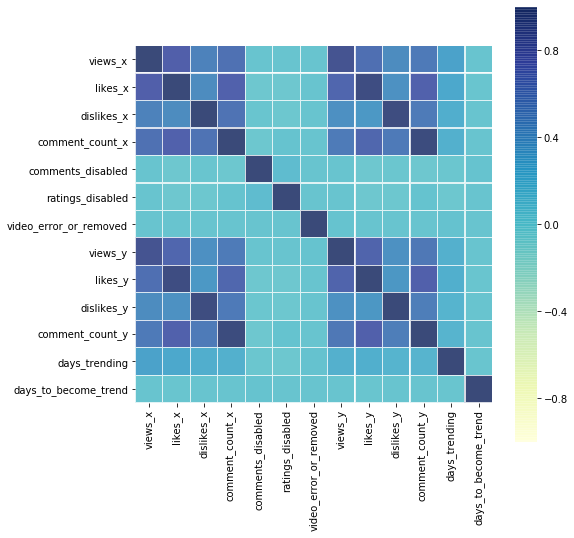

In [217]:
plt.figure(figsize = (8,8))
ax = sns.heatmap(full_df.corr(), alpha = 0.8, cmap = 'YlGnBu', linewidths=.3, square = True, vmin=-1, vmax=1)

#Adjusting bottom and top rows
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5);

There's a correlation between trending days and number of likes, dislikes and comments, however, it's just about 0.3, not really high.

### Most popular tags and words in description

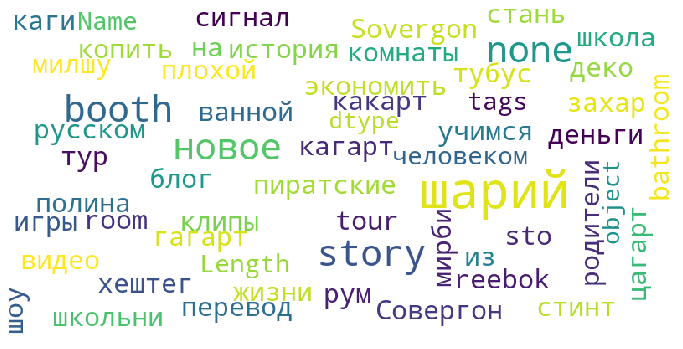

In [279]:
from wordcloud import WordCloud

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        max_words=200,
        max_font_size=30, 
        scale=2,
        random_state=100, 
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(df['tags'].apply(lambda x: x.replace('|', " ").replace("\"", "")))

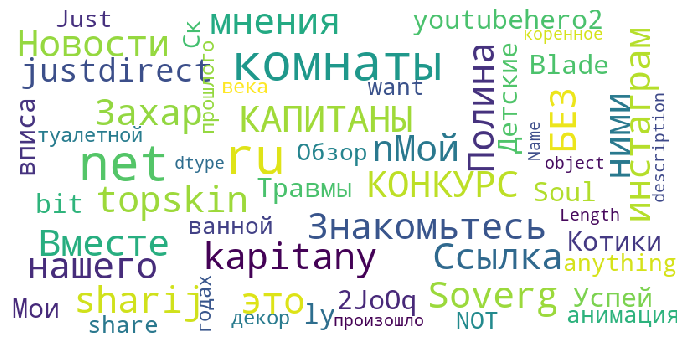

In [252]:
show_wordcloud(df['description'])

#### What are the most common words in the most disliked category (News and Politics?)

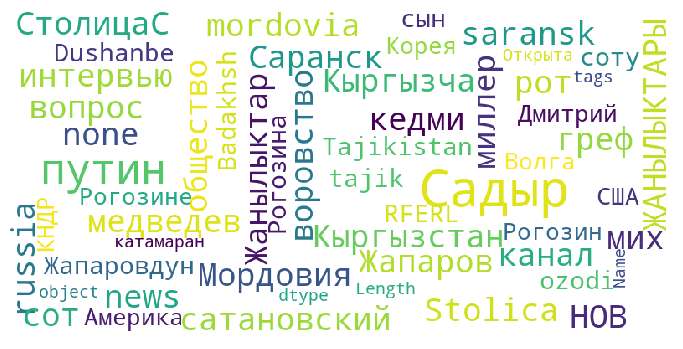

In [361]:
show_wordcloud(df[df['category_name'] == 'News & Politics']['tags'].apply(lambda x: x.replace('|', " ").replace("\"", "")))

For some reason there are a lot of kazach/tajik words here. You can also see names frequent in the media like German Gref, Putin, Medvedev, Rogozin. Among other interesting words are USA, theft, capital.

### Which are the videos which are removed or have disabled comments or ratings?

In [331]:
df[df['video_error_or_removed']][['title','channel_title','description','category_name', 'views','likes', 'dislikes', 'comment_count', 'comments_disabled', 'ratings_disabled']]

,title,channel_title,description,category_name,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled
4744,Deleted video,Это не Диалоги О Рыбалке,Извините за косяк в монтаже.\nРыбалка на Север...,Howto & Style,52382,2600,70,260,False,False
10100,Deleted video,CryptoManiac,Enjoyed watching How to Buy Bitcoins in Canada...,Science & Technology,49307,581,0,36,False,False
15506,Deleted video,Новости на Первом Канале,Минфин США в понедельник опубликовал «кремлевс...,News & Politics,11840,61,31,0,False,False
16189,Deleted video,Александр Северный,Власть толкает страну к политическому дефолту!...,People & Blogs,2961,320,10,109,False,False
30733,Earth Day 2018 Google Doodle,googledoodles,Today’s annual Earth Day Doodle was created in...,Film & Animation,7318,654,17,93,False,False
32934,360 Google Doodles/Spotlight Stories: Back to ...,Google Spotlight Stories,"The Google Doodle, Google Spotlight Stories, G...",Film & Animation,118998,10399,4527,2334,False,False


Only 6 removed/videos with error. Nothing special, rather low comment_count, number of likes and dislikes. The last 2 videos look like temporary videos made and then deleted by google.

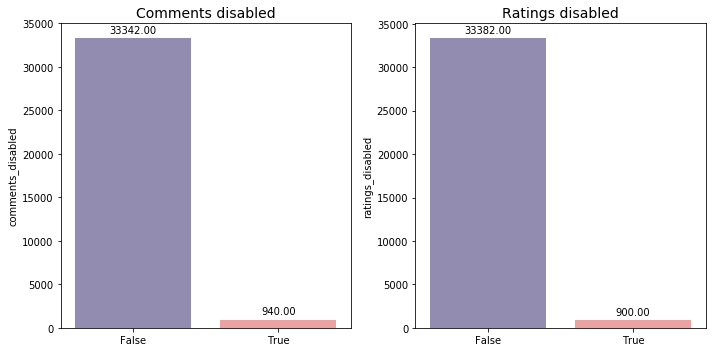

In [303]:
fig = plt.gcf()
fig.set_size_inches(10, 5)

plt.subplot(1,2,1)
ax = sns.barplot(y = df['comments_disabled'].value_counts(), 
                 x = df['comments_disabled'].value_counts().index.tolist(), palette = ['#7268A6','#F57D7C'], alpha = 0.8)
ax.set_title('Comments disabled', fontsize = 14)
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., 
        p.get_height()), ha = 'center', va = 'center', xytext = (0, 8), textcoords = 'offset points', fontsize = 10)
plt.tight_layout();

plt.subplot(1,2,2)
ax2 = sns.barplot(y = df['ratings_disabled'].value_counts(), 
                 x = df['ratings_disabled'].value_counts().index.tolist(), palette = ['#7268A6','#F57D7C'], alpha = 0.8)
ax2.set_title('Ratings disabled', fontsize = 14)
for p in ax2.patches:
    ax2.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., 
        p.get_height()), ha = 'center', va = 'center', xytext = (0, 8), textcoords = 'offset points', fontsize = 10)
plt.tight_layout();

In [307]:
df[df['comments_disabled']][['title', 'channel_title','description','views', 'likes', 'dislikes']]

,title,channel_title,description,views,likes,dislikes
60,Взрослый разговор. Еда будущего или вот такая ...,Mediametrics Live,13-11-2017 12:00\n\nДаже самые на первый взгля...,21814,9,46
72,Вот это таджик Русккий народ смотрите,TAJIK show,NaN,570184,3778,447
89,Глава ДНР Александр Захарченко об участившихся...,Первый Республиканский Телеканал,NaN,18077,0,0
152,Нас будет трое...,PVWEDDING,Кирилл Андреев и Нэлли Ермолаева сообщили о то...,176550,2022,1319
190,Kisabac Lusamutner eter 13.11.17 Ushagnac Kaper,KisabacLusamutner,ՈՒՇԱԳՆԱՑ ԿԱՊԵՐ - Լիանա Հարությունյանը վստահեցն...,18434,72,14
...,...,...,...,...,...,...
40584,"Իմ ձեռով պիտի սատկացնեմ Մանվելին, իրա վախճանը ...",ArmLur.аm,NaN,124347,2066,43
40680,Անցուդարձ 13.06.2018,Kentron Channel,https://kentron.tvhttps://www.facebook.com/ken...,30856,53,186
40706,Gevorg Martirosyan & Spitakci Hayko - Bola Bol...,DJ NAREK Official,instagram-https://www.instagram.com/zaqoyannar...,101059,3152,88
40715,Ахбори Тоҷикистон ва ҷаҳон (13.06.2018)اخبار ت...,Ozodivideo,"Ҷазо барои дӯстдорони пора сахттар шуд, Барои ...",78982,712,124


There are videos with arab and what looks like hebrew languages in the title or descriptions. Let's look at which categories they belong. Also, it doesn't look like those are highly disliked videos but let's check it.

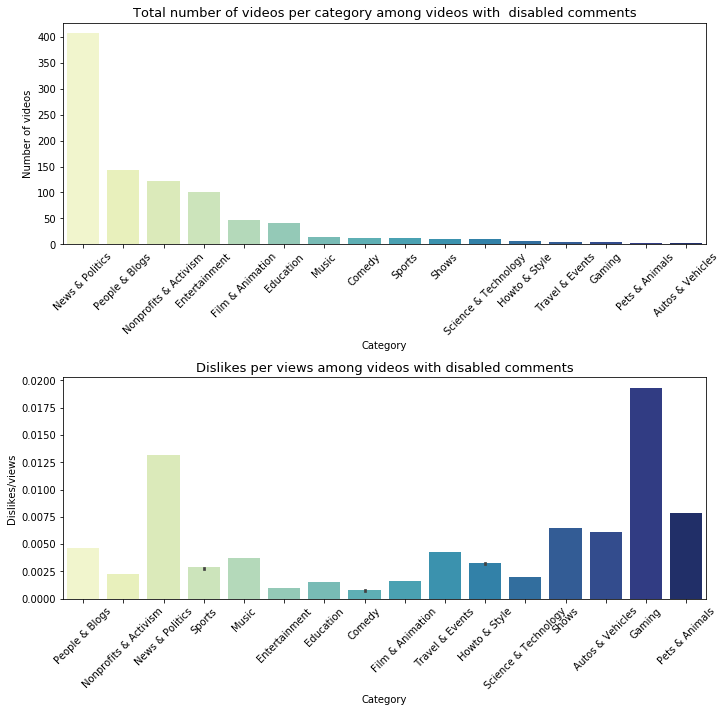

In [351]:
plt.figure(figsize = (10,10))
plt.subplot(211)
ax1 = sns.barplot(y = df[df['comments_disabled']]['category_name'].value_counts().reset_index()['category_name'],
                  x = df[df['comments_disabled']]['category_name'].value_counts().reset_index()['index'],palette= 'YlGnBu')
ax1.set_title('Total number of videos per category among videos with  disabled comments', fontsize = 13)
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=45)
plt.tight_layout()
ax1.set_xlabel('Category')
ax1.set_ylabel('Number of videos');

plt.subplot(212)
ax2 = sns.barplot(y = df[df['comments_disabled']]['dislikes']/df[df['comments_disabled']]['views'],
                  x = df[df['comments_disabled']]['category_name'] ,palette= 'YlGnBu', ci = 1)
ax2.set_title('Dislikes per views among videos with disabled comments', fontsize = 13)
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=45)
plt.tight_layout()
ax2.set_xlabel('Category')
ax2.set_ylabel('Dislikes/views');

As predicted, the majority of videos with disabled comments belong to politics. Maybe this has to do with the fact that this is the least liked category and people don't want negative thread under their videos. However, this category is not the most disliked, surprisingly, it's gaming.

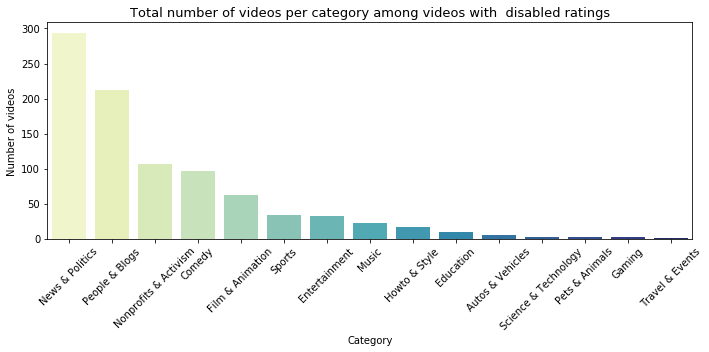

In [358]:
plt.figure(figsize = (10,5))
ax1 = sns.barplot(y = df[df['ratings_disabled']]['category_name'].value_counts().reset_index()['category_name'],
                  x = df[df['ratings_disabled']]['category_name'].value_counts().reset_index()['index'],palette= 'YlGnBu')
ax1.set_title('Total number of videos per category among videos with  disabled ratings', fontsize = 13)
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=45)
plt.tight_layout()
ax1.set_xlabel('Category')
ax1.set_ylabel('Number of videos');

Similar to what we saw with disabled comments.